In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import edward as ed
import tensorflow as tf
from edward.models import Multinomial, Dirichlet, DirichletMultinomial
import seaborn as sns

In [2]:
N = 100

In [3]:
p = Dirichlet(tf.constant(1., shape=(3,)))
y = Multinomial(total_count=N * 6., probs=p)

In [4]:
T = 500
qp = ed.models.Empirical(tf.get_variable("p", [T, 3], initializer=tf.constant_initializer(1.0 / 3)))

In [6]:
inference = ed.Gibbs({p: qp}, data={y: [N * i for i in [4., 1., 1.]]})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()



TypeError: initialize() got an unexpected keyword argument 'n_samples'

In [30]:
p_post = ed.copy(qp)

In [43]:
samples = qp.sample(1000).eval()
print(qp.mean().eval())
print(samples[:,:10])

[nan nan nan]
[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 ...
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]


In [26]:
print(f"{type(qp)}\n{type(p)}")

<class 'abc.Dirichlet'>
<class 'abc.Dirichlet'>


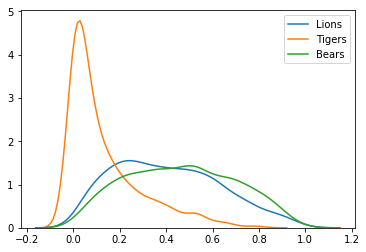

In [7]:
sns.kdeplot(data=samples[:,0], label="Lions")
sns.kdeplot(samples[:,1], label="Tigers")
sns.kdeplot(samples[:,2], label="Bears")

In [18]:
inputs = tf.placeholder('float', [None, 2], name='Inputs')

In [20]:
weights = tf.Variable(tf.random_normal(shape=[2, 3], stddev=0.02), name="Weights")

In [21]:
outputs = tf.matmul(inputs, weights)

In [24]:
print(f"{type(inputs)}\n{type(weights)}\n{type(outputs)}")

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.ops.variables.Variable'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [65]:
import numpy as np

def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    return x

N = 500
D = 2
x_train = build_toy_dataset(N)

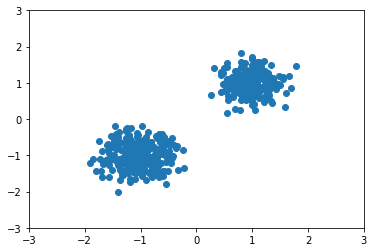

In [83]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [ ]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture

K = 2 # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)